# Classifying high vs low custody level

## Initial classification

**Notebook Setup**

In [34]:
#!pip install bioinfokit

In [35]:
import sys
sys.path.append("../src")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
#from heatmap import heatmap
import statsmodels.formula.api as smf
#import bioinfokit

In [37]:
plt.style.use('ggplot')

In [47]:
%matplotlib inline

from project import rf_models, preprocessing

df = pd.read_csv("../data/initial_custody_2017_gsprs.csv", low_memory=False)

df['high_ic_instit_adj'] = np.where(df['ic_institut_adj']>2, 1, 0)
df['ic_override_up'] = np.where(df['ic_ovride_cust_lvl']-df['ic_custdy_level']>0,1,0)
df['high_ic'] = np.where(df['ic_custdy_level']>3, 1, 0)


# preprocessing
data = preprocessing.preprocess_input_vars(df)
data = data[data.ic_custdy_level > 1]
data = data[
    [
        "gender_female",
        "age_gt_45",
        "age_lt_25",
        "race_B",
        "race_A",
        "race_H",
        "race_I",
        "race_O",
        "off_1_prs_max",
        "off_1_gs_max",
        #"ic_custdy_level",
        "prior_commits",
        "ic_institut_adj",
        "escape_hist_1",
        #"escape_hist_2",
        #"escape_hist_3",
        #"escape_hist_4",
        "escape_hist_5",
        "mrt_stat_DIV",
        "mrt_stat_SEP",
        "mrt_stat_MAR",
        "mrt_stat_WID",
        "employed",
        #"high_ic_instit_adj",
        "high_ic"
    ]
]
data = data.dropna()

df_ic_all = data

#### Exploratory data analysis

In [48]:
df_ic_all['high_ic'].value_counts()

1    7750
0    6065
Name: high_ic, dtype: int64

In [49]:
count_hi = len(df_ic_all[df_ic_all['high_ic']==0])
count_lo = len(df_ic_all[df_ic_all['high_ic']==1])
pct_hi = count_hi/(count_hi+count_lo)
print("percentage of high lev is", pct_hi*100)
pct_lo = count_lo/(count_hi+count_lo)
print("percentage of low lev is", pct_lo*100)

percentage of high lev is 43.90155627940644
percentage of low lev is 56.09844372059356


#### See how quantitative variables vary with custody level

In [50]:
df_ic_all.groupby('high_ic').mean()['prior_commits']

high_ic
0    3.226216
1    3.330968
Name: prior_commits, dtype: float64

In [51]:
df_ic_all.groupby('high_ic').mean()['off_1_gs_max']

high_ic
0    10.915581
1    12.455613
Name: off_1_gs_max, dtype: float64

In [52]:
df_ic_all.groupby('high_ic').mean()['off_1_prs_max']

high_ic
0    2.363726
1    2.648839
Name: off_1_prs_max, dtype: float64

In [53]:
df_ic_all.groupby('high_ic').mean()['ic_institut_adj']

high_ic
0    2.297939
1    3.816258
Name: ic_institut_adj, dtype: float64

####  See how quantitative variables vary with race_B

In [54]:
#df_ic_all.groupby('race_B').mean()['ic_custdy_level']

race_B
0    3.272099
1    3.644472
Name: ic_custdy_level, dtype: float64

In [13]:
df_ic_all.groupby('race_B').mean()['ic_institut_adj']

race_B
0    2.949816
1    3.328127
Name: ic_institut_adj, dtype: float64

In [14]:
df_ic_all.groupby('race_B').mean()['off_1_prs_max']

race_B
0    2.401013
1    2.633169
Name: off_1_prs_max, dtype: float64

In [15]:
df_ic_all.groupby('race_B').mean()['off_1_gs_max']

race_B
0    11.151473
1    12.340184
Name: off_1_gs_max, dtype: float64

In [16]:
df_ic_all.groupby('race_B').mean()['prior_commits']

race_B
0    3.343002
1    3.233183
Name: prior_commits, dtype: float64

#### Visualizations

Text(0, 0.5, 'Count of people')

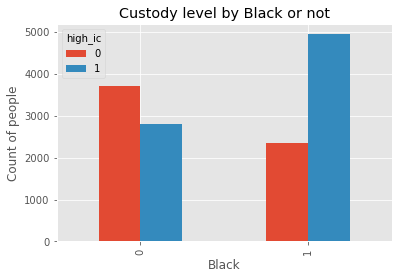

In [17]:
%matplotlib inline
pd.crosstab(df_ic_all.race_B,df_ic_all.high_ic).plot(kind='bar')
plt.title('Custody level by Black or not')
plt.xlabel('Black')
plt.ylabel('Count of people')

Text(0, 0.5, 'Proportion of people')

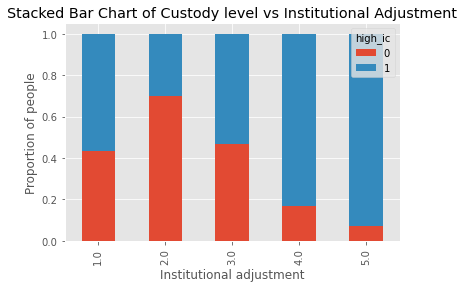

In [18]:
table=pd.crosstab(df_ic_all.ic_institut_adj,df_ic_all.high_ic)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Institutional Adjustment')
plt.xlabel('Institutional adjustment')
plt.ylabel('Proportion of people')

Text(0, 0.5, 'Proportion of people')

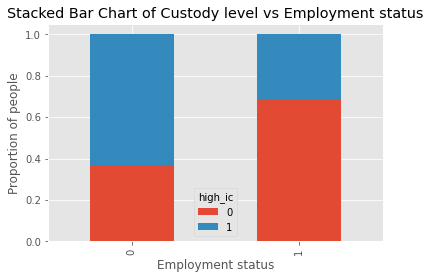

In [19]:
table=pd.crosstab(df_ic_all.employed,df_ic_all.high_ic)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Employment status')
plt.xlabel('Employment status')
plt.ylabel('Proportion of people')

Text(0, 0.5, 'Proportion of people')

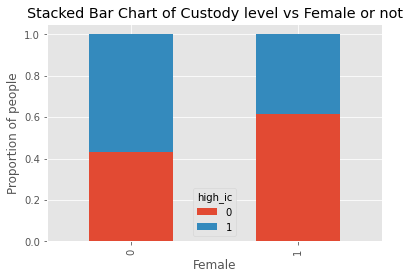

In [20]:
table=pd.crosstab(df_ic_all.gender_female,df_ic_all.high_ic)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Custody level vs Female or not')
plt.xlabel('Female')
plt.ylabel('Proportion of people')

### Building the full model with all features used by the PACT

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [22]:
data_final = df_ic_all

Optimization terminated successfully.
         Current function value: 0.437898
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.361     
Dependent Variable: high_ic          AIC:              12137.1222
Date:               2021-12-03 22:18 BIC:              12280.2589
No. Observations:   13815            Log-Likelihood:   -6049.6   
Df Model:           18               LL-Null:          -9472.8   
Df Residuals:       13796            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
age_gt_45        -1.2860   0.0696 -18.4665 0.0000 -1.4225 -1.1495
ic_institut_adj   0.7361   0.0185  39.6932 0.0000  0.6997  0.7724


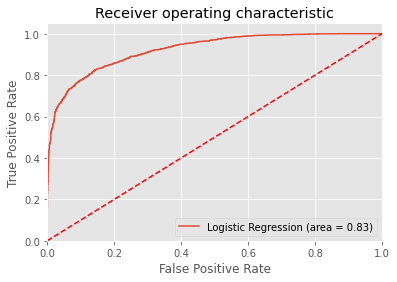

In [23]:
#We ommitted escape histories 2, 3 and 4 because they were highly correlated with escape history 1
#and because we want to know if they're frequent escapees or not, and not necessarily how many times

data_final_vars=data_final.columns.values.tolist()
yvars = ['high_ic']
Xvars = [i for i in data_final_vars if i not in yvars]
X = data_final.loc[:, data_final.columns != 'high_ic']
y = data_final.loc[:, data_final.columns == 'high_ic']
ll = ['age_gt_45',
 'ic_institut_adj',
 'escape_hist_1',
 #'escape_hist_2',
 #'escape_hist_3',
 #'escape_hist_4',
 'escape_hist_5',
 'mrt_stat_DIV',
 'mrt_stat_SEP',
 'mrt_stat_MAR',
 'mrt_stat_WID',
 'employed']
ll.append('race_B')
ll.append('race_A')
ll.append('race_H')
ll.append('race_I')
ll.append('race_O')
ll.append('off_1_gs_max')
ll.append('off_1_prs_max')
ll.append('prior_commits')
ll.append('age_lt_25')
ll.append('gender_female')
X = X[ll]
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())
print(model_odds)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train.values.ravel())
y_pred = logreg.predict(X_test)
print('\nAccuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("\n")
print(cm)
print("\n")
print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


#### Checking conditions on this model

In [24]:
# Absence of colinearity
Xc = np.asarray(X.corr())
print(Xc.min())
print(Xc[Xc < 1].max())

-0.3625729098397436
0.2716285891254191


In [25]:
X.corr()

,age_gt_45,ic_institut_adj,escape_hist_1,escape_hist_5,mrt_stat_DIV,mrt_stat_SEP,mrt_stat_MAR,mrt_stat_WID,employed,race_B,race_A,race_H,race_I,race_O,off_1_gs_max,off_1_prs_max,prior_commits,age_lt_25,gender_female
age_gt_45,1.000000,-0.198292,0.036324,-0.040152,0.271629,0.068148,0.100073,0.115500,0.114381,-0.103700,-0.000714,-0.047862,0.005757,-0.009228,-0.097557,0.067116,0.203549,-0.249819,0.005241
ic_institut_adj,-0.198292,1.000000,-0.069795,0.082658,-0.114433,-0.059488,-0.094304,-0.039029,-0.157529,0.141996,-0.014481,0.027124,0.005421,0.005378,0.076324,-0.004263,-0.038069,0.238531,-0.012389
escape_hist_1,0.036324,-0.069795,1.000000,-0.163816,0.040004,0.022963,0.025134,0.019090,0.116160,-0.062252,0.013838,-0.005512,-0.005951,-0.000276,0.105121,-0.122262,-0.334744,0.073472,0.023615
escape_hist_5,-0.040152,0.082658,-0.163816,1.000000,-0.016387,-0.012601,-0.004069,-0.011420,-0.035352,0.002637,0.010037,0.000354,-0.005217,-0.010038,-0.052512,-0.003258,0.029433,0.031762,-0.013423
mrt_stat_DIV,0.271629,-0.114433,0.040004,-0.016387,1.000000,-0.067926,-0.102458,-0.034823,0.112132,-0.177743,-0.014814,-0.036396,-0.001031,-0.000635,-0.035792,-0.029074,0.036456,-0.171271,0.002811
mrt_stat_SEP,0.068148,-0.059488,0.022963,-0.012601,-0.067926,1.000000,-0.073633,-0.025026,0.056731,-0.070018,-0.010646,-0.016290,0.004426,0.004473,-0.025622,-0.005067,0.018166,-0.112079,0.018519
mrt_stat_MAR,0.100073,-0.094304,0.025134,-0.004069,-0.102458,-0.073633,1.000000,-0.037749,0.137970,-0.069920,0.014062,0.003111,0.013384,0.009030,0.001687,0.016908,0.015858,-0.150253,0.012240
mrt_stat_WID,0.115500,-0.039029,0.019090,-0.011420,-0.034823,-0.025026,-0.037749,1.000000,0.042901,-0.044680,-0.005458,-0.024025,-0.003476,0.026311,0.011914,-0.010611,0.012969,-0.059909,0.060434
employed,0.114381,-0.157529,0.116160,-0.035352,0.112132,0.056731,0.137970,0.042901,1.000000,-0.127797,-0.000168,-0.049286,0.006480,0.025028,-0.034565,-0.039719,-0.058357,-0.181530,-0.001099
race_B,-0.103700,0.141996,-0.062252,0.002637,-0.177743,-0.070018,-0.069920,-0.044680,-0.127797,1.000000,-0.050997,-0.362573,-0.032482,-0.062495,0.193031,0.099250,-0.016123,0.184157,-0.053614


#### Continuous IVs linearly related to log odss

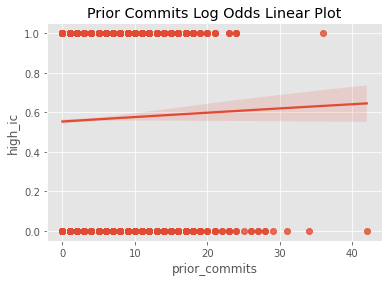

In [26]:
prior_commits = sns.regplot(x= 'prior_commits', y= 'high_ic', data=data_final, logistic= True).set_title("Prior Commits Log Odds Linear Plot")



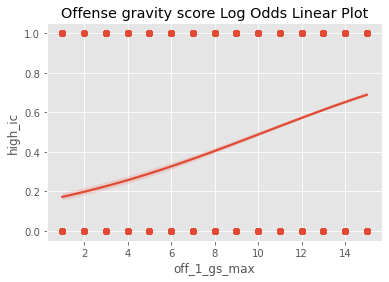

In [27]:
off_1_gs_max = sns.regplot(x= 'off_1_gs_max', y= 'high_ic', data=data_final, logistic= True).set_title("Offense gravity score Log Odds Linear Plot")


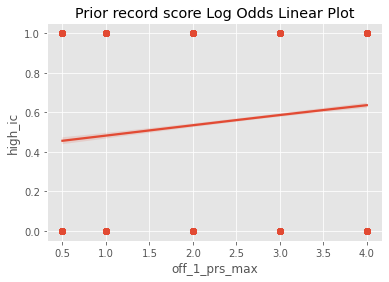

In [28]:
off_1_prs_max = sns.regplot(x= 'off_1_prs_max', y= 'high_ic', data=data_final, logistic= True).set_title("Prior record score Log Odds Linear Plot")


#### Outliers

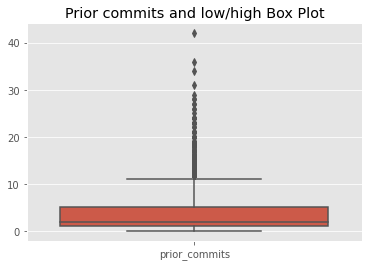

In [29]:
prior_commits_box = sns.boxplot(data= data_final[['prior_commits']]).set_title("Prior commits and low/high Box Plot")


/home/ncr006/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ncr006/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


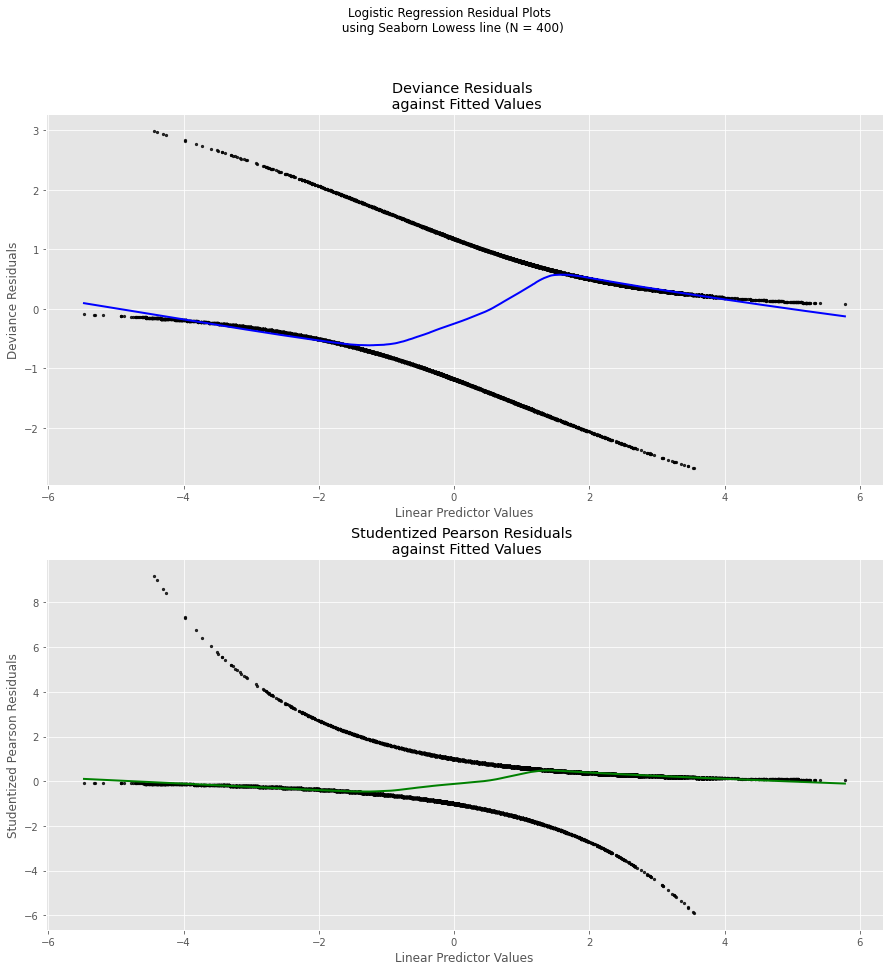

In [30]:
#### Residuals
## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")


# Deviance Residuals
sns.regplot(result.fittedvalues, result.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(result.fittedvalues, result.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()

### Feature selection

In [31]:
ll = ['age_gt_45',
 'ic_institut_adj',
 'escape_hist_1',
 #'escape_hist_2',
 #'escape_hist_3',
 #'escape_hist_4',
 'escape_hist_5',
 'mrt_stat_DIV',
 'mrt_stat_SEP',
 'mrt_stat_MAR',
 'mrt_stat_WID',
 'employed']
ll.append('race_B')
ll.append('race_A')
ll.append('race_H')
ll.append('race_I')
ll.append('race_O')
ll.append('off_1_gs_max')
ll.append('off_1_prs_max')
ll.append('prior_commits')
ll.append('age_lt_25')
ll.append('gender_female')

In [32]:
yvars = ['high_ic']
Xvars = [i for i in data_final_vars if i not in yvars]
X = data_final.loc[:, data_final.columns != 'high_ic']
y = data_final.loc[:, data_final.columns == 'high_ic']
X=X[ll]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=500) # increase the number of iterations to get convergence
rfe = RFE(logreg, n_features_to_select=4, step=1)
rfe = rfe.fit(X, y.values.ravel())

In [33]:
zz= list(zip(Xvars,list(rfe.support_)))
features = [a for (a,b) in zz if b]
features

['gender_female', 'race_B', 'race_A', 'race_H']